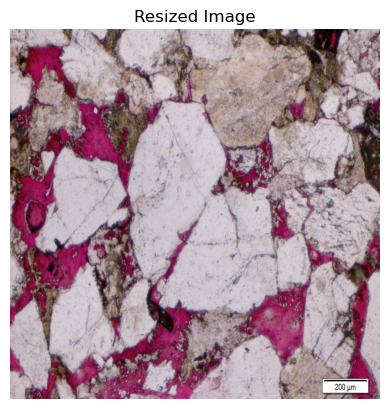

Number of masks generated: 301


In [39]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def filter_masks(masks, threshold):
    filter_masks = []
    total = masks[0]['segmentation'].shape[0] * masks[0]['segmentation'].shape[1]
    for i, mask_data in enumerate(masks):
        mask = mask_data["segmentation"]
        # filter
        total_value = np.sum(mask)
        percentage = total_value / total
        if percentage > threshold:
            continue
        filter_masks.append(mask_data)
    return filter_masks

## visual
def save_anns(image, anns, save_path):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    plt.axis('off')
    plt.savefig(save_path)
    plt.close()

def write_masks_to_folder(image, masks, path, image_suffix, threshold=None):
    header = "id,area,bbox_x0,bbox_y0,bbox_w,bbox_h,point_input_x,point_input_y,predicted_iou,stability_score,crop_box_x0,crop_box_y0,crop_box_w,crop_box_h"  # noqa
    metadata = [header]
    # filter masks
    if threshold is not None:
        masks = filter_masks(masks, threshold)
    # save visual annotation fig
    save_anns(image, masks, os.path.join(path, 'full_mask'+image_suffix))
    # save each mask
    for i, mask_data in enumerate(masks):
        mask = mask_data["segmentation"]
        filename = f"{i}"+image_suffix
        cv2.imwrite(os.path.join(path, filename), mask * 255)
        mask_metadata = [
            str(i),
            str(mask_data["area"]),
            *[str(x) for x in mask_data["bbox"]],
            *[str(x) for x in mask_data["point_coords"][0]],
            str(mask_data["predicted_iou"]),
            str(mask_data["stability_score"]),
            *[str(x) for x in mask_data["crop_box"]],
        ]
        row = ",".join(mask_metadata)
        metadata.append(row)
    metadata_path = os.path.join(path, "metadata.csv")
    with open(metadata_path, "w") as f:
        f.write("\n".join(metadata))
    return

sam_checkpoint = '/home/a6/vis/LDS/SAM/weights/sam_vit_h_4b8939.pth'
model_type = 'vit_h'
device = 'cuda'
image_path = '/home/a6/vis/LDS/SAM/images/S1-B6m2-.png'

# create sam
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_model.to(device=device)
# sam_model.eval()
mask_generator = SamAutomaticMaskGenerator(
    model=sam_model,
    points_per_side=64,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.75,
    crop_n_layers=2,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

# load image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image=cv2.resize(image,(1024,1024))

# 使用 matplotlib 展示图像
plt.imshow(image)
plt.title('Resized Image')
plt.axis('off')  # 隐藏坐标轴
plt.show()

masks = mask_generator.generate(image)
print(f'Number of masks generated: {len(masks)}')

# specify the directory to save masks
masks_dir = '/home/a6/vis/LDS/SAM/masks'
os.makedirs(masks_dir, exist_ok=True)

# save masks to the specified directory
write_masks_to_folder(image, masks, masks_dir, '.png', threshold=0.3)

In [41]:
import json
import logging
import torch.nn.functional as F
import torch

# 创建 logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

output_dir = '/home/a6/vis/LDS/SAM/outputs'
mask_vec_npy_dir = os.path.join(output_dir, 'npy_masks')
json_mask_avg_vec_save_path = os.path.join(output_dir, 'json_masks')
# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(mask_vec_npy_dir, exist_ok=True)
os.makedirs(json_mask_avg_vec_save_path, exist_ok=True)

image_torch = torch.as_tensor(image, device=device)
transformed_image = image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
input_image = sam_model.preprocess(transformed_image)
with torch.no_grad():
    image_embedding = sam_model.image_encoder(input_image)  # [B, C, H, W]
b, c, h, w = image_embedding.shape

# Process each mask
masked_feature_list = {}
mask_files = [f for f in os.listdir(masks_dir) if f.endswith('.png')]
mask_vecs = []
for mask_file in mask_files:
    mask_path = os.path.join(masks_dir, mask_file)
    mask_name = os.path.splitext(mask_file)[0]
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask.astype(np.float32) / 255.0  # Normalize mask to [0, 1]
    mask = torch.as_tensor(mask, device=device)[None, None, :, :]  # [1, 1, H, W]
    
    # Rescale features and mask
    rescale_factor = 4  # 4x upsample/downsample
    t1, t2 = int(mask.shape[2] / rescale_factor), int(mask.shape[3] / rescale_factor)
    features_rescale = F.interpolate(image_embedding, size=[t1, t2], mode='bilinear')
    mask_rescale = F.interpolate(mask, size=[t1, t2], mode='bilinear')

    masked_feature = torch.mul(features_rescale, mask_rescale)
    masked_feature = masked_feature.view(b, c, -1)
    non_zero_count = torch.count_nonzero(masked_feature, dim=2)
    
    # Calculate average vector for mask
    masked_avg_vec = masked_feature.sum(dim=2) / non_zero_count
    masked_avg_vec[torch.isnan(masked_avg_vec)] = 0
    
    # Save masked feature vector
    npy_data = masked_avg_vec.detach().cpu().numpy()
    single_mask_vec_path = os.path.join(mask_vec_npy_dir, mask_name + '.npy')
    np.save(single_mask_vec_path, npy_data)
    masked_feature_list[mask_name] = single_mask_vec_path
    mask_vecs.append(npy_data)

# Save image and mask info to JSON
img_info = {
    'image_name': os.path.basename(image_path),
    'mask_avg_vec': masked_feature_list
}
json_save_name = os.path.join(json_mask_avg_vec_save_path, os.path.splitext(os.path.basename(image_path))[0] + '_mask_vec.json')
with open(json_save_name, "w") as file:
    json.dump(img_info, file)

logger.info(f'Saving image: {os.path.basename(image_path)} all masks as {json_save_name}.')



In [7]:
import os
import cv2
import torch
import numpy as np
import torch.nn.functional as F

# 加载和处理图像
image_torch = torch.as_tensor(image, device=device)
transformed_image = image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
input_image = sam_model.preprocess(transformed_image)
with torch.no_grad():
    image_embedding = sam_model.image_encoder(input_image)  # [B, C, H, W]

# 加载掩码
mask1_path = '/home/a6/vis/LDS/SAM/masks/174.png'
mask2_path = '/home/a6/vis/LDS/SAM/masks/191.png'
mask1 = cv2.imread(mask1_path, cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread(mask2_path, cv2.IMREAD_GRAYSCALE)

# 归一化掩码
mask1 = torch.as_tensor(mask1.astype(np.float32) / 255.0, device=device)[None, None, :, :]
mask2 = torch.as_tensor(mask2.astype(np.float32) / 255.0, device=device)[None, None, :, :]

# 调整掩码和特征图大小
rescale_factor = 4  # Example factor
t1, t2 = mask1.shape[2] // rescale_factor, mask1.shape[3] // rescale_factor
features_rescale = F.interpolate(image_embedding, size=[t1, t2], mode='bilinear')
mask1_rescale = F.interpolate(mask1, size=[t1, t2], mode='bilinear')
mask2_rescale = F.interpolate(mask2, size=[t1, t2], mode='bilinear')

# 应用掩码
masked_features1 = features_rescale * mask1_rescale
masked_features2 = features_rescale * mask2_rescale

# 计算每个通道在两个掩码下的平均激活值
masked_features1_flat = masked_features1.view(masked_features1.shape[1], -1)
masked_features2_flat = masked_features2.view(masked_features2.shape[1], -1)

# 计算非零元素的数量
non_zero_count1 = (masked_features1_flat != 0).sum(dim=1).float()
non_zero_count2 = (masked_features2_flat != 0).sum(dim=1).float()

# 计算通道响应
channel_responses1 = masked_features1_flat.sum(dim=1) / (non_zero_count1 + 1e-6)
channel_responses2 = masked_features2_flat.sum(dim=1) / (non_zero_count2 + 1e-6)

# 计算响应差异
response_differences = channel_responses1 - channel_responses2

# 找到响应差异最大的通道（掩码1上敏感，掩码2上不敏感）
most_effective_channel = torch.argmax(response_differences)
print("Most effective channel for Mask1 and least for Mask2:", most_effective_channel.item())
print("Difference in activation values for most effective channel:", response_differences[most_effective_channel].item())

# 创建一个包含索引、激活值和差异的列表
channels_data = list(zip(range(channel_responses1.shape[0]), channel_responses1, channel_responses2, response_differences))

# 按照掩码1激活值从大到小排序
channels_data_sorted = sorted(channels_data, key=lambda x: x[1], reverse=True)

# 打印所有通道的激活值和激活值差异（按照掩码1激活值从大到小排序）
print("All channel activation values and differences (sorted by Mask1 activation):")
for idx, resp1, resp2, diff in channels_data_sorted:
    print(f"Channel {idx}: Mask1 Activation = {resp1.item()}, Mask2 Activation = {resp2.item()}, Difference = {diff.item()}")


Most effective channel for Mask1 and least for Mask2: 149
Difference in activation values for most effective channel: 0.2837219834327698
All channel activation values and differences (sorted by Mask1 activation):
Channel 207: Mask1 Activation = 0.2632766366004944, Mask2 Activation = 0.16880640387535095, Difference = 0.09447023272514343
Channel 153: Mask1 Activation = 0.22762423753738403, Mask2 Activation = 0.32238081097602844, Difference = -0.09475657343864441
Channel 244: Mask1 Activation = 0.21926748752593994, Mask2 Activation = 0.02069622464478016, Difference = 0.19857126474380493
Channel 94: Mask1 Activation = 0.21288803219795227, Mask2 Activation = 0.20673808455467224, Difference = 0.006149947643280029
Channel 149: Mask1 Activation = 0.21182668209075928, Mask2 Activation = -0.07189531624317169, Difference = 0.2837219834327698
Channel 130: Mask1 Activation = 0.20976565778255463, Mask2 Activation = 0.08814980089664459, Difference = 0.12161585688591003
Channel 252: Mask1 Activation =

In [43]:
import os
import cv2
import torch
import numpy as np
import torch.nn.functional as F
import json
import logging

# 设置日志
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# 定义输出路径
output_dir = '/home/a6/vis/LDS/SAM/outputs'
mask_vec_npy_dir = os.path.join(output_dir, 'npy_masks')
json_mask_avg_vec_save_path = os.path.join(output_dir, 'json_masks')
os.makedirs(output_dir, exist_ok=True)
os.makedirs(mask_vec_npy_dir, exist_ok=True)
os.makedirs(json_mask_avg_vec_save_path, exist_ok=True)

# 加载和处理图像
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_torch = torch.as_tensor(image, device=device)  # 需要先定义image
transformed_image = image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
input_image = sam_model.preprocess(transformed_image)  # 需要定义sam_model
with torch.no_grad():
    image_embedding = sam_model.image_encoder(input_image)

# 加载掩码
mask1_path = '/home/a6/vis/LDS/SAM/masks/281.png'
mask2_path = '/home/a6/vis/LDS/SAM/masks/191.png'
mask1 = cv2.imread(mask1_path, cv2.IMREAD_GRAYSCALE)
mask2 = cv2.imread(mask2_path, cv2.IMREAD_GRAYSCALE)

# 归一化并调整掩码大小
mask1 = torch.tensor(mask1.astype(np.float32) / 255.0, device=device).unsqueeze(0).unsqueeze(0)
mask2 = torch.tensor(mask2.astype(np.float32) / 255.0, device=device).unsqueeze(0).unsqueeze(0)
rescale_factor = 4
t1, t2 = int(mask1.shape[2] / rescale_factor), int(mask1.shape[3] / rescale_factor)
mask1_rescale = F.interpolate(mask1, size=[t1, t2], mode='bilinear')
mask2_rescale = F.interpolate(mask2, size=[t1, t2], mode='bilinear')

# 应用掩码并计算响应
features_rescale = F.interpolate(image_embedding, size=[t1, t2], mode='bilinear')
masked_features1 = features_rescale * mask1_rescale
masked_features2 = features_rescale * mask2_rescale

# 计算非零元素的数量
non_zero_count1 = (masked_features1 != 0).sum(dim=(2, 3))
non_zero_count2 = (masked_features2 != 0).sum(dim=(2, 3))

# 计算总和，并排除零值
channel_sums1 = masked_features1.view(features_rescale.shape[1], -1).sum(dim=1)
channel_sums2 = masked_features2.view(features_rescale.shape[1], -1).sum(dim=1)

# 计算平均响应，只计算非零元素的平均
channel_responses1 = channel_sums1 / (non_zero_count1 + 1e-6)
channel_responses2 = channel_sums2 / (non_zero_count2 + 1e-6)

# 平移激活值使其非负
min_response = min(channel_responses1.min(), channel_responses2.min())
shift = -min_response if min_response < 0 else 0
channel_responses1 += shift
channel_responses2 += shift

# # 计算响应差异
# response_differences = channel_responses1 - channel_responses2

# # 基于掩码1和掩码2的激活值差异计算权重
# # weights = torch.clamp(response_differences, min=0)  # 负值置零

# # 标准化和缩放
# mean_diff = response_differences.mean()
# std_diff = response_differences.std()
# normalized_weights = (response_differences - mean_diff) / (std_diff + 1e-6)
# scaled_weights = torch.sigmoid(normalized_weights)  # 使用Sigmoid函数将值缩放到[0, 1]范围
# # 基于掩码1和掩码2的激活值差异计算权重,
# # 1.掩码1激活值大且掩码2激活值的通道 2.通道2的激活值小于0的通道才会被考虑
# # weights = torch.where(response_differences > 0, scaled_weights, torch.tensor(0.0, device=device))
# weights = torch.where((response_differences > 0) & (channel_responses2-shift < 0), scaled_weights, torch.tensor(0.0, device=device))


## 方法2
# 找出符合条件的通道
valid_conditions = (response_differences > 0) & (channel_responses2 - shift < 0)

# 计算符合条件通道的均值和标准差
valid_diffs = response_differences[valid_conditions]
mean_diff = valid_diffs.mean()
std_diff = valid_diffs.std()

# 仅对符合条件的通道进行标准化和缩放
normalized_weights = (response_differences - mean_diff) / (std_diff + 1e-6)
scaled_weights = torch.sigmoid(normalized_weights)
weights = torch.where(valid_conditions, scaled_weights, torch.tensor(0.0, device=device))

print(weights[0][59])
print(weights)

# 遍历掩码文件并应用权重
masked_feature_list = {}
mask_files = [f for f in os.listdir(masks_dir) if f.endswith('.png')]
for mask_file in mask_files:
    mask_path = os.path.join(masks_dir, mask_file)
    mask_name = os.path.splitext(mask_file)[0]
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = torch.tensor(mask.astype(np.float32) / 255.0, device=device).unsqueeze(0).unsqueeze(0)
    mask_rescale = F.interpolate(mask, size=[t1, t2], mode='bilinear')
    masked_feature = torch.mul(features_rescale, mask_rescale)
    weighted_feature = masked_feature * weights.view(1, -1, 1, 1)  # 应用权重
    avg_feature = weighted_feature.view(weighted_feature.shape[1], -1).mean(dim=1)
    npy_data = avg_feature.detach().cpu().numpy()
    single_mask_vec_path = os.path.join(mask_vec_npy_dir, mask_name + '.npy')
    np.save(single_mask_vec_path, npy_data)
    masked_feature_list[mask_name] = single_mask_vec_path

# 保存掩码和特征信息到JSON
img_info = {'image_name': 'name_of_your_image.jpg', 'mask_avg_vec': masked_feature_list}  # 定义image_path或直接使用图像名
json_save_name = os.path.join(json_mask_avg_vec_save_path, 'mask_vec_info.json')
with open(json_save_name, "w") as file:
    json.dump(img_info, file)

logger.info(f'Saved image and masks info as {json_save_name}.')


tensor(0.8508, device='cuda:0')
tensor([[0.7625, 0.0000, 0.4129, 0.0000, 0.0000, 0.3172, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3862, 0.0000,
         0.0000, 0.2891, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3193, 0.4422,
         0.4169, 0.0000, 0.0000, 0.0000, 0.0000, 0.2910, 0.3654, 0.4628, 0.3818,
         0.0000, 0.0000, 0.0000, 0.3646, 0.3570, 0.0000, 0.2973, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.3847, 0.0000, 0.0000, 0.4001, 0.0000, 0.8508, 0.0000, 0.0000, 0.5415,
         0.0000, 0.9491, 0.0000, 0.0000, 0.0000, 0.0000, 0.3370, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6693, 0.2970, 0.0000, 0.0000,
         0.3625, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3767, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3051, 0.4588, 0.0000,
         0.0000, 0.3222, 0.0000, 0.0000, 0.0000, 0.9289, 0.0000, 0.4887, 0.00

(256,)
Filtered indices: [  2   5  15  22  25  29  31  32  35  44  46  48  62  64  65  68  69  77
  80  84  93 103 110 114 115 116 128 131 132 138 139 140 144 162 163 165
 172 173 174 182 186 192 199 202 214 215 219 226 231 233 234 237 242 243
 247 253 265 271 273 276 280 281 282 288 289 297 299 300]
Filtered similarities: [0.73575854 0.78924245 0.99920726 0.6000057  0.5466529  0.7493237
 0.6463569  0.65169245 0.5261106  0.77966857 0.7125454  0.7607624
 0.85291505 0.520754   0.5031236  0.63317895 0.7138461  0.71332335
 0.62001044 0.7054921  0.83731306 0.8092211  0.61685157 0.87403727
 0.9112428  0.6863393  0.50381064 0.6117754  0.58621824 0.51116633
 0.7370641  0.7100124  0.62193424 0.6817682  0.8522601  0.5806229
 0.71145356 0.70415115 0.9999999  0.53336674 0.6535442  0.6011255
 0.54084253 0.9058535  0.5121483  0.8680883  0.71333    0.5434543
 0.77372247 0.7124316  0.9939096  0.69355375 0.7908349  0.5683352
 0.54287255 0.82964635 0.5495633  0.7189816  0.61700976 0.65864456
 0.5410185 

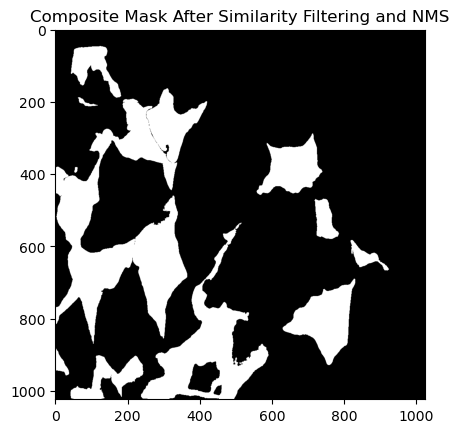

In [47]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision.ops import nms

# 加载所有 .npy 文件的特征向量
npy_dir = '/home/a6/vis/LDS/SAM/outputs/npy_masks'
npy_files = [f for f in os.listdir(npy_dir) if f.endswith('.npy')]
mask_dir = '/home/a6/vis/LDS/SAM/masks'

features = []
file_names = []

for npy_file in npy_files:
    file_path = os.path.join(npy_dir, npy_file)
    features.append(np.load(file_path))
    file_names.append(npy_file)

# 将特征向量转换为 NumPy 数组
features = np.array(features).squeeze()  # Assuming features are [N, D]

# 指定查询的文件名
query_file_name = "281.npy"  # 替换为你要查询的文件名
if query_file_name in file_names:
    query_index = file_names.index(query_file_name)
    query_feature = features[query_index]
    print(query_feature.shape)
else:
    raise ValueError(f"File {query_file_name} not found in the directory.")

# 计算相似性
similarities = cosine_similarity([query_feature], features)[0]

# 设定查询阈值
threshold = 0.5

# 找到相似度大于阈值的特征向量
filtered_indices = np.where(similarities > threshold)[0]
filtered_similarities = similarities[filtered_indices]

print(f"Filtered indices: {filtered_indices}")
print(f"Filtered similarities: {filtered_similarities}")

# 生成边界框并应用NMS
bboxes = []
scores = []

for idx in filtered_indices:
    mask_name = os.path.splitext(file_names[idx])[0] + '.png'
    mask_path = os.path.join(mask_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        continue
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    bboxes.append([x_min, y_min, x_max, y_max])
    scores.append(similarities[idx])  # Use the correct similarity for NMS

# 转换为张量
bboxes = torch.tensor(bboxes, dtype=torch.float32)
scores = torch.tensor(scores, dtype=torch.float32)

# 应用非极大抑制
nms_indices = nms(bboxes, scores, iou_threshold=0.3)

# 打印最终保留下来的掩码信息
print("Kept masks after similarity filtering and NMS:")
for idx in nms_indices:
    mask_name = os.path.splitext(file_names[filtered_indices[idx]])[0] + '.png'
    print(f"File: {mask_name}")

# 绘制复合掩码图像
image_shape = (1024, 1024)  # Assuming all masks are of this shape
composite_image = np.zeros(image_shape, dtype=np.float32)

for idx in nms_indices:
    mask_name = os.path.splitext(file_names[filtered_indices[idx]])[0] + '.png'
    mask_path = os.path.join(mask_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
    composite_image = np.maximum(composite_image, mask)

# 绘制复合掩码图像
plt.imshow(composite_image, cmap='gray')
plt.title('Composite Mask After Similarity Filtering and NMS')
plt.show()


In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision.ops import nms

# 加载所有 .npy 文件的特征向量
npy_dir = '/home/a6/vis/LDS/SAM/outputs/npy_masks'
npy_files = [f for f in os.listdir(npy_dir) if f.endswith('.npy')]
mask_dir = '/home/a6/vis/LDS/SAM/masks'

features = []
file_names = []

for npy_file in npy_files:
    file_path = os.path.join(npy_dir, npy_file)
    features.append(np.load(file_path))
    file_names.append(npy_file)

# 将特征向量转换为 NumPy 数组
features = np.array(features).squeeze()  # Assuming features are [N, D]

# 指定两个聚类中心的文件名
center_file_1 = "83.npy"  # 替换为你要作为聚类中心的文件名
center_file_2 = "183.npy"  # 替换为你要作为聚类中心的文件名

# 获取聚类中心的特征
if center_file_1 in file_names and center_file_2 in file_names:
    center_feature_1 = features[file_names.index(center_file_1)]
    center_feature_2 = features[file_names.index(center_file_2)]
else:
    raise ValueError("One or both center files not found in the directory.")

# 使用KMeans进行二分类，指定初始聚类中心
initial_centers = np.array([center_feature_1, center_feature_2])
kmeans = KMeans(n_clusters=2, init=initial_centers, n_init=1, random_state=0)
labels = kmeans.fit_predict(features)

# 找到包含center_file_1的聚类结果
cluster_id_1 = labels[file_names.index(center_file_1)]
cluster_indices_1 = np.where(labels == cluster_id_1)[0]
print(f"Cluster containing {center_file_1}: {len(cluster_indices_1)} masks")

# 对聚类结果进行相似度查询，仅保留相似度大于0.7的掩码
filtered_indices = []
filtered_similarities = []
for idx in cluster_indices_1:
    similarity = cosine_similarity([features[idx]], [center_feature_1])[0][0]
    if similarity > 0.6:
        filtered_indices.append(idx)
        filtered_similarities.append(similarity)

# 生成边界框并打印过滤前的掩码信息
print("Filtered masks before NMS:")
bboxes = []
scores = []
for idx, similarity in zip(filtered_indices, filtered_similarities):
    mask_name = os.path.splitext(file_names[idx])[0] + '.png'
    print(f"File: {mask_name}")
    mask_path = os.path.join(mask_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0 or len(x_indices) == 0:
        continue
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    bboxes.append([x_min, y_min, x_max, y_max])
    scores.append(similarity)  # Use the correct similarity for NMS

# 转换为张量
bboxes = torch.tensor(bboxes, dtype=torch.float32)
scores = torch.tensor(scores, dtype=torch.float32)

# 应用非极大抑制
nms_indices = nms(bboxes, scores, iou_threshold=0.3)

# 打印被去除的掩码信息
removed_indices = set(filtered_indices) - set(filtered_indices[idx] for idx in nms_indices)
print("Removed masks by NMS:")
for idx in removed_indices:
    mask_name = os.path.splitext(file_names[idx])[0] + '.png'
    print(f"File: {mask_name}")

# 打印最终保留下来的掩码信息
print(f"Kept masks in Cluster containing {center_file_1} after similarity filtering and NMS:")
for idx in nms_indices:
    mask_name = os.path.splitext(file_names[filtered_indices[idx]])[0] + '.png'
    print(f"File: {mask_name}")

# 绘制复合掩码图像
image_shape = (1024, 1024)  # Assuming all masks are of this shape
composite_image = np.zeros(image_shape, dtype=np.float32)

for idx in nms_indices:
    mask_name = os.path.splitext(file_names[filtered_indices[idx]])[0] + '.png'
    mask_path = os.path.join(mask_dir, mask_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
    composite_image = np.maximum(composite_image, mask)

# 绘制复合掩码图像
plt.imshow(composite_image, cmap='gray')
plt.title(f'Composite Mask of Cluster containing {center_file_1}')
plt.show()
